In [18]:
Swan = False
if Swan == True:
    %run Utils.py

In [19]:
%matplotlib widget
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
from matplotlib.ticker import LogFormatter 
from Utils import *
from scipy.optimize import curve_fit
import copy
import os
import h5py
import json

import PyPDF2                       # Per unire i PDF alla fine
import glob                         # Per manipolazione dei path

from collections.abc import Iterable


In [20]:
config_file = r"./config.json"
# print (config_file)

with open(config_file, "r") as f:
            dizi = json.load(f)
        
dizi

{'RunAllignment': 680165,
 'RunEqualizer': 680245,
 'd_12': 925,
 'd_1c': 953,
 'offset_x2': 1.1971159313901332,
 'offset_y2': -0.602845866465819,
 'div_12x': 0.00027084777701111897,
 'div_12y': 0.0005041808584579469,
 'slope': 1267.8363660825437,
 'intercept': -33.01827637034396,
 'data_path': '/eos/project/i/insulab-como/testBeam/TB_T9_2023_08_OREO/HDF5',
 'slope_LG': 1.2678363660825436,
 'intercept_LG': -33.01827637034396,
 'slope_George': 5.818640711274588,
 'intercept_George': 33.69249929879056,
 'eq_George': 1.807518256041887,
 'slope_John': 4.450998710147237,
 'intercept_John': 29.389963525634204,
 'eq_John': 1.0,
 'slope_Paul': 7.032407741185125,
 'intercept_Paul': 25.03120462365356,
 'eq_Paul': 1.4486540496404077}

(10372, 3)
(11519, 3)
[[21.849, 40.4235, 30.122750000000003], [22.038, 38.895, 25.007250000000003]]


/Users/ncanale/anaconda3/envs/Python/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


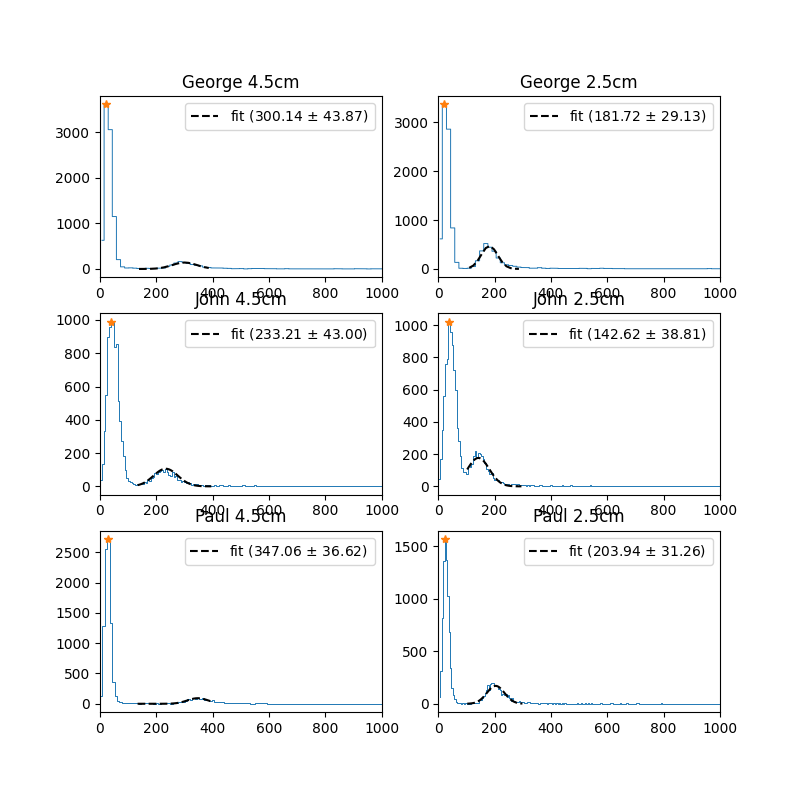

In [22]:
n_runs = [680244,680245]

dept = [4.5,2.5]

fig, ax = plt.subplots(3,2)
fig.set_size_inches(8,8)
En_values     = []
sigma_values  = []
peak_values = []
for i, run in enumerate(n_runs):
    # print(str(Beam_en[i])+' GeV')
    xpos,xinfo,ph,tm,evi,Beatles,x1,y1,x2,y2,x_cry,y_cry = file_corrector(run)
    print(Beatles.shape)
    George = Beatles[:,0]
    John = Beatles[:,1]
    Paul = Beatles[:,2]
    Check_shapes = False
    if Check_shapes:
        ax[0,i].hist(George,2000,label = 'George ' +str(dept[i]) + 'cm')
        ax[1,i].hist(John,2000,label = 'John ' +str(dept[i]) + 'cm')
        ax[2,i].hist(Paul,2000,label = 'Paul ' +str(dept[i]) + 'cm')
        for j in range(3):
            ax[j,i].set_xlim(0,1000)
            ax[j,i].legend(fontsize = 10)
    else:
        fit_range_min = [130,100]
        fit_range_max = [400,300]
        Sipm_Th  = 80
        # hG, binsG = np.histogram(George[George>Sipm_Th], 1000)
        # hJ, binsJ = np.histogram(John[John>Sipm_Th], 2000) #, label = (str(Beam_en[i])+' GeV'))
        # hP, binsP = np.histogram(Paul[Paul>Sipm_Th], 2000) #, label = (str(Beam_en[i])+' GeV'))
        hG, binsG = np.histogram(George, 1000)
        hJ, binsJ = np.histogram(John, 2000) #, label = (str(Beam_en[i])+' GeV'))
        hP, binsP = np.histogram(Paul, 2000) #, label = (str(Beam_en[i])+' GeV'))

        bincG = binsG[:-1] + (binsG[1] - binsG[0]) / 2
        bincJ = binsJ[:-1] + (binsJ[1] - binsJ[0]) / 2
        bincP = binsP[:-1] + (binsP[1] - binsP[0]) / 2
        fit_rangeG = (bincG >= fit_range_min[i]) & (bincG <= fit_range_max[i])
        fit_rangeJ = (bincJ >= fit_range_min[i]) & (bincJ <= fit_range_max[i])
        fit_rangeP = (bincP >= fit_range_min[i]) & (bincP <= fit_range_max[i])

        x_fitG = bincG[fit_rangeG]
        x_fitJ = bincJ[fit_rangeJ]
        x_fitP = bincP[fit_rangeP]
        
        y_fitG = hG[fit_rangeG]
        y_fitJ = hJ[fit_rangeJ]
        y_fitP = hP[fit_rangeP]
       
        ##    guesses
        p0G = (max(y_fitG), x_fitG[np.argmax(y_fitG)], len(x_fitG))
        p0J = (max(y_fitJ), x_fitJ[np.argmax(y_fitJ)], len(x_fitJ))
        p0P = (max(y_fitP), x_fitP[np.argmax(y_fitP)], len(x_fitP))
        # print(p0)
    
        fit_poptG, pcovG = curve_fit(myGauss, x_fitG, y_fitG, sigma = np.sqrt(y_fitG), absolute_sigma = True, p0 = p0G)
        fit_poptJ, pcovJ = curve_fit(myGauss, x_fitJ, y_fitJ, sigma = np.sqrt(y_fitJ), absolute_sigma = True, p0 = p0J)
        fit_poptP, pcovP = curve_fit(myGauss, x_fitP, y_fitP, sigma = np.sqrt(y_fitP), absolute_sigma = True, p0 = p0P)
        
        peak_values.append([bincG[np.argmax(hG)],bincJ[np.argmax(hJ)],bincP[np.argmax(hP)]])
        En_values.append([fit_poptG[1],fit_poptJ[1],fit_poptP[1]])
        sigma_values.append([fit_poptG[2],fit_poptJ[2],fit_poptP[2]])

        ax[0,i].plot(bincG, hG, ds = "steps-mid", lw = .7)
        ax[0,i].plot(bincG[np.argmax(hG)],np.max(hG),'*')
        ax[1,i].plot(bincJ, hJ, ds = "steps-mid", lw = .7)
        ax[1,i].plot(bincJ[np.argmax(hJ)],np.max(hJ),'*')
        ax[2,i].plot(bincP, hP, ds = "steps-mid", lw = .7)
        ax[2,i].plot(bincP[np.argmax(hP)],np.max(hP),'*')
        ax[0,i].plot(x_fitG, myGauss(x_fitG, *fit_poptG), ls = "--", c = "k", label = f"fit ({fit_poptG[1]:.2f} $\pm$ {fit_poptG[2]:.2f}) ")
        ax[1,i].plot(x_fitJ, myGauss(x_fitJ, *fit_poptJ), ls = "--", c = "k", label = f"fit ({fit_poptJ[1]:.2f} $\pm$ {fit_poptJ[2]:.2f}) ")
        ax[2,i].plot(x_fitP, myGauss(x_fitP, *fit_poptP), ls = "--", c = "k", label = f"fit ({fit_poptP[1]:.2f} $\pm$ {fit_poptP[2]:.2f}) ")
        for j in range(3):
            ax[j,i].set_xlim(0,1000)
            ax[j,i].legend(fontsize = 10)
        ax[0,i].set_title('George ' +str(dept[i]) + 'cm')
        ax[1,i].set_title('John ' +str(dept[i]) + 'cm')
        ax[2,i].set_title('Paul ' +str(dept[i]) + 'cm')

    
print(peak_values)

# print(En_values)
# print(sigma_values)
plt.show()

In [23]:
print(peak_values)

print(peak_values[0][0])
print(peak_values[0][1])
print(peak_values[0][2])

print(peak_values[1][0])
print(peak_values[1][1])
print(peak_values[1][2])


[[21.849, 40.4235, 30.122750000000003], [22.038, 38.895, 25.007250000000003]]
21.849
40.4235
30.122750000000003
22.038
38.895
25.007250000000003


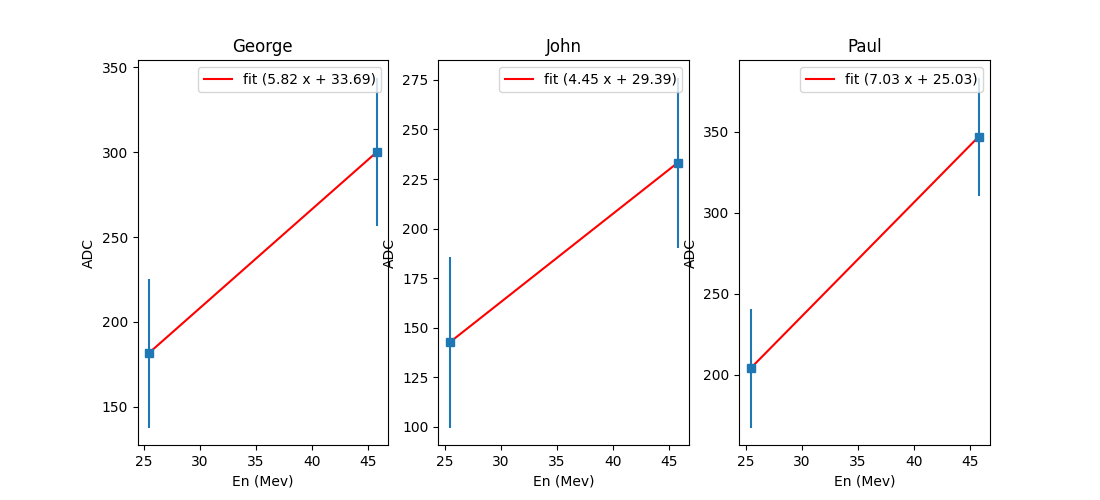

[1.850130440752437, 1.0, 1.341959150475969]
[1.764906071331337, 1.0, 1.5553489488048466]

[1.807518256041887, 1.0, 1.4486540496404077]


In [24]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(11,5)
Energy= []
for pos in dept:
    #energy_loss_mip_in_PWO= 1.229*pos*8.28 #MeV
    Energy.append(1.229*pos*8.28) #MeV
    # Energy.append(1.229*pos*8.28) #MeV
names = ['George','John','Paul']
eq_factor =[1.0,1.0,1.0]
eq_factor_a =[1.0,1.0,1.0]
eq_factor_b =[1.0,1.0,1.0]
# ax[0].errorbar(Energy,[En_values[0][0],En_values[1][0]],[sigma_values[0][0],sigma_values[0][0]],marker='s',ls='')
for i in range(3):
    Y_values = [En_values[0][i],En_values[1][i]]
    Y_err = [sigma_values[0][i],sigma_values[0][i]]
    ax[i].errorbar(Energy,Y_values,Y_err,marker='s',ls='')
    slope, intercept = np.polyfit(Energy, Y_values, 1)
    fit_line = slope * np.array(Energy) + intercept
    NewData={"slope_"+names[i]: slope, "intercept_"+names[i]: intercept}
    dizi.update(NewData)
    fit_minusq=slope * np.array(Energy)
    # Plot the linear fit
    ax[i].plot(Energy, fit_line, color='red', label=f"fit ({slope:.2f} x + {intercept:.2f})")
    ax[i].set_xlabel('En (Mev)')
    ax[i].set_ylabel('ADC')
    ax[i].set_title(names[i])
    ax[i].legend()
    eq_factor[i] = ((peak_values[0][1]/peak_values[0][i])+(peak_values[1][1]/peak_values[1][i]))/2
    eq_factor_a[i] = (peak_values[0][1]/peak_values[0][i])
    eq_factor_b[i] = (peak_values[1][1]/peak_values[1][i])
    diz_eq={"eq_"+names[i]: eq_factor[i]}
    dizi.update(diz_eq)
plt.show()
print(eq_factor_a)
print(eq_factor_b)
print()
print(eq_factor)
##### upload new element to the json file 
with open(config_file, "w") as f:
            json.dump(dizi, f, indent=4)


(10372, 3)
[ 37  34 270 ... 290  30  29]
[ 66.87817547  61.45562071 488.02992913 ... 524.18029425  54.22554768
  52.41802943]
(11519, 3)
[34 31 44 ... 22 27 15]
[61.45562071 56.03306594 79.53080327 ... 39.76540163 48.80299291
 27.11277384]


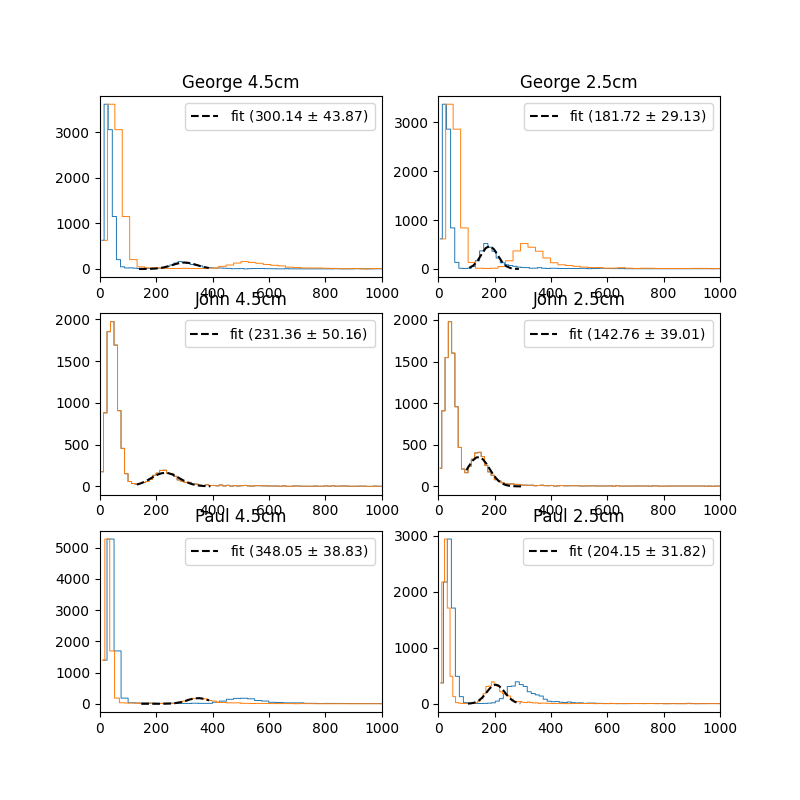

In [25]:
equalized = True

if equalized:
    n_runs = [680244,680245]

dept = [4.5,2.5]

fig, ax = plt.subplots(3,2)
fig.set_size_inches(8,8)
En_values     = []
sigma_values  = []
peak_values = []
for i, run in enumerate(n_runs):
    # print(str(Beam_en[i])+' GeV')
    xpos,xinfo,ph,tm,evi,Beatles,x1,y1,x2,y2,x_cry,y_cry = file_corrector(run)
    print(Beatles.shape)
    George = Beatles[:,0]
    print(George)
    John = Beatles[:,1]
    Paul = Beatles[:,2]
    George_eq = George*dizi['eq_George']
    print(George_eq)
    John_eq = John*dizi['eq_John']
    Paul_eq = Paul*dizi['eq_Paul']
    Check_shapes = False
    if Check_shapes:
        ax[0,i].hist(George_eq,2000,label = 'George_eq ' +str(dept[i]) + 'cm')
        ax[1,i].hist(John_eq,2000,label = 'John_eq ' +str(dept[i]) + 'cm')
        ax[2,i].hist(Paul_eq,2000,label = 'Paul_eq ' +str(dept[i]) + 'cm')
        for j in range(3):
            ax[j,i].set_xlim(0,1000)
            ax[j,i].legend(fontsize = 10)
    else:
        fit_range_min = [130,100]
        fit_range_max = [400,300]
        Sipm_Th  = 80
     
        hG, binsG = np.histogram(George, 1000)
        hJ, binsJ = np.histogram(John, 1000)
        hP, binsP = np.histogram(Paul, 1000)

        bincG = binsG[:-1] + (binsG[1] - binsG[0]) / 2
        bincJ = binsJ[:-1] + (binsJ[1] - binsJ[0]) / 2
        bincP = binsP[:-1] + (binsP[1] - binsP[0]) / 2
       
        hG_eq, binsG_eq = np.histogram(George_eq, 1000)
        hJ_eq, binsJ_eq = np.histogram(John_eq, 1000)
        hP_eq, binsP_eq = np.histogram(Paul_eq, 1000)

        bincG_eq = binsG_eq[:-1] + (binsG_eq[1] - binsG_eq[0]) / 2
        bincJ_eq = binsJ_eq[:-1] + (binsJ_eq[1] - binsJ_eq[0]) / 2
        bincP_eq = binsP_eq[:-1] + (binsP_eq[1] - binsP_eq[0]) / 2
       
        fit_rangeG = (bincG >= fit_range_min[i]) & (bincG <= fit_range_max[i])
        fit_rangeJ = (bincJ >= fit_range_min[i]) & (bincJ <= fit_range_max[i])
        fit_rangeP = (bincP >= fit_range_min[i]) & (bincP <= fit_range_max[i])

        x_fitG = bincG[fit_rangeG]
        x_fitJ = bincJ[fit_rangeJ]
        x_fitP = bincP[fit_rangeP]
        
        y_fitG = hG[fit_rangeG]
        y_fitJ = hJ[fit_rangeJ]
        y_fitP = hP[fit_rangeP]
       
        ##    guesses
        p0G = (max(y_fitG), x_fitG[np.argmax(y_fitG)], len(x_fitG))
        p0J = (max(y_fitJ), x_fitJ[np.argmax(y_fitJ)], len(x_fitJ))
        p0P = (max(y_fitP), x_fitP[np.argmax(y_fitP)], len(x_fitP))
        # print(p0)
    
        fit_poptG, pcovG = curve_fit(myGauss, x_fitG, y_fitG, sigma = np.sqrt(y_fitG), absolute_sigma = True, p0 = p0G)
        fit_poptJ, pcovJ = curve_fit(myGauss, x_fitJ, y_fitJ, sigma = np.sqrt(y_fitJ), absolute_sigma = True, p0 = p0J)
        fit_poptP, pcovP = curve_fit(myGauss, x_fitP, y_fitP, sigma = np.sqrt(y_fitP), absolute_sigma = True, p0 = p0P)
        
        peak_values.append([bincG[np.argmax(hG)],bincJ[np.argmax(hJ)],bincP[np.argmax(hP)]])
        En_values.append([fit_poptG[1],fit_poptJ[1],fit_poptP[1]])
        sigma_values.append([fit_poptG[2],fit_poptJ[2],fit_poptP[2]])

        ax[0,i].plot(bincG, hG, ds = "steps-mid", lw = .7)
        ax[0,i].plot(bincG_eq, hG_eq, ds = "steps-mid", lw = .7)
                
        ax[1,i].plot(bincJ_eq, hJ_eq, ds = "steps-mid", lw = .7)
        ax[1,i].plot(bincJ, hJ, ds = "steps-mid", lw = .7)
                
        ax[2,i].plot(bincP_eq, hP_eq, ds = "steps-mid", lw = .7)
        ax[2,i].plot(bincP, hP, ds = "steps-mid", lw = .7)
                
        ax[0,i].plot(x_fitG, myGauss(x_fitG, *fit_poptG), ls = "--", c = "k", label = f"fit ({fit_poptG[1]:.2f} $\pm$ {fit_poptG[2]:.2f}) ")
        ax[1,i].plot(x_fitJ, myGauss(x_fitJ, *fit_poptJ), ls = "--", c = "k", label = f"fit ({fit_poptJ[1]:.2f} $\pm$ {fit_poptJ[2]:.2f}) ")
        ax[2,i].plot(x_fitP, myGauss(x_fitP, *fit_poptP), ls = "--", c = "k", label = f"fit ({fit_poptP[1]:.2f} $\pm$ {fit_poptP[2]:.2f}) ")
        for j in range(3):
            ax[j,i].set_xlim(0,1000)
            ax[j,i].legend(fontsize = 10)
        ax[0,i].set_title('George ' +str(dept[i]) + 'cm')
        ax[1,i].set_title('John ' +str(dept[i]) + 'cm')
        ax[2,i].set_title('Paul ' +str(dept[i]) + 'cm')
    

##### upload new element to the json file 
with open(config_file, "w") as f:
            json.dump(dizi, f, indent=4)



OGNI BEATLE CON IL SUO SLOPE -Q --> misura in MeV e li sommi

poi LG, 6-LG e Beatles united

(Fiudiciali?!)

In [25]:
xpos,xinfo,ph,tm,evi,Beatles,x1,y1,x2,y2,x_cry,y_cry = file_corrector(680294)
fig, ax = plt.subplots(2)

ax[0].hist(Beatles[:,1][Beatles[:,1]>200],500)
ax[1].hist(Beatles[:,1][Beatles[:,1]>2000],500,density=True)

xpos,xinfo,ph,tm,evi,Beatles,x1,y1,x2,y2,x_cry,y_cry = file_corrector(680293)
ax[0].hist(Beatles[:,1][Beatles[:,1]>200],500)
ax[1].hist(Beatles[:,1][Beatles[:,1]>2000],500,density=True)



plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …